# VASP CdTe benchmark performance

This notebook compares the performance of the CdTe benchmark across different HPC facilities.

We compute the max time per SCF cycle from all cycles in the output file. Performance is plotted as SCF cycles per second (i.e. inverse of maximum SCF cycle time in seconds) 

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [5]:
results = ['ARCHER','ARCHER2','ARCHER2-MKL193']
systems = {'ARCHER': 'ARCHER', 'ARCHER2': 'ARCHER2', 'ARCHER2-MKL193': 'ARCHER2'}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../CdTe_Hybrid/results/' + res
    filelist = filemanip.get_filelist(wdir, 'CdTe_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
8     192       1       12   2     0.000169  0.000169  0.000169  0.000169   
16    384       1       8    2     0.000272  0.000272  0.000272  0.000272   
                        24   2     0.000328  0.000328  0.000328  0.000328   
32    768       1       8    2     0.000217  0.000217  0.000217  0.000217   
                        48   2     0.000599  0.000599  0.000599  0.000599   
50    1200      1       75   2     0.000900  0.000900  0.000900  0.000900   
64    1536      1       96   2     0.000983  0.000983  0.000983  0.000983   

                                         SCF                                   \
                                         min     median        max       mean   
Nodes Processes Threads NPAR KPAR                          

                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
1     128       1       4    2     0.000090  0.000090  0.000090  0.000090   
                        8    2     0.000089  0.000089  0.000089  0.000089   
                        16   2     0.000097  0.000097  0.000097  0.000097   
2     256       1       4    2     0.000142  0.000142  0.000142  0.000142   
                        8    2     0.000178  0.000178  0.000178  0.000178   
                        16   2     0.000134  0.000134  0.000134  0.000134   
                        32   2     0.000183  0.000183  0.000184  0.000183   
4     512       1       8    2     0.000281  0.000281  0.000281  0.000281   
                        16   2     0.000319  0.000319  0.000319  0.000319   
                        32   2     0.000292  0.000292  0.000292  0.000292   

## Performance Comparison

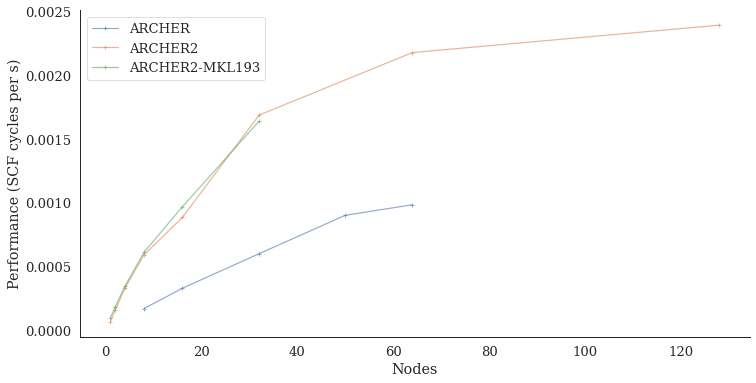

In [6]:
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

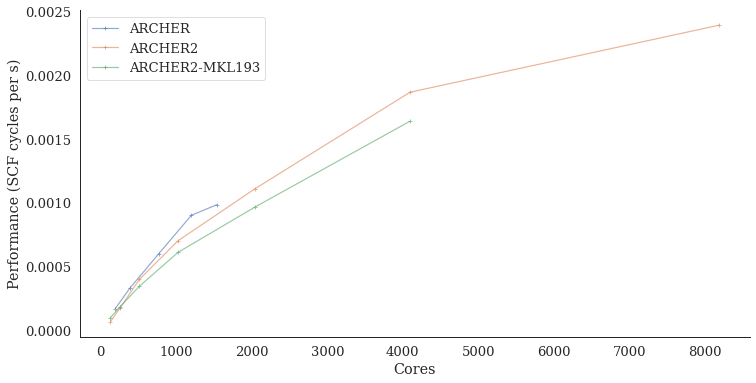

In [7]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

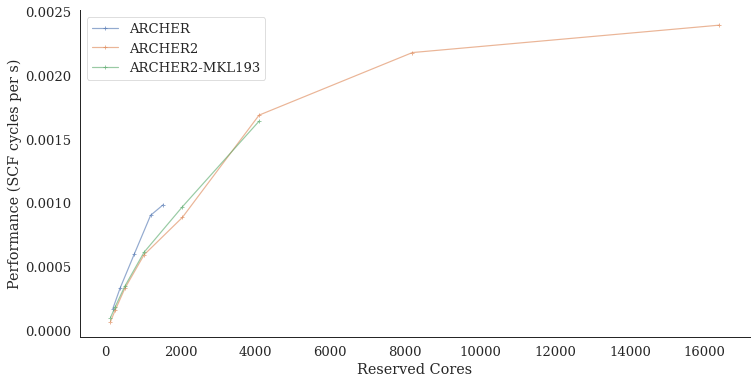

In [8]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

## ARCHER2 Cray LibSci vs. MKL performance

A comparison of the performance of the same version of VASP using different numerical libraries

In [9]:
print(f"{'Nodes':>5s} {'LibSci':>10s} {'MKL':>10s} {'Ratio':>10s}")
for i in range(min(len(nodes['ARCHER2']),len(nodes['ARCHER2-MKL193']))):
    n = nodes['ARCHER2'][i]
    perfLS = perf_nodes['ARCHER2'][i]
    perfMKL = perf_nodes['ARCHER2-MKL193'][i]
    ratio = perfLS/perfMKL
    print(f"{n:>5d} {perfLS:>10.5f} {perfMKL:>10.5f} {ratio:>10.5f}")

Nodes     LibSci        MKL      Ratio
    1    0.00007    0.00010    0.67783
    2    0.00016    0.00018    0.85430
    4    0.00033    0.00034    0.94954
    8    0.00059    0.00061    0.96701
   16    0.00088    0.00097    0.91373
   32    0.00169    0.00164    1.02890
